有效数据条数：1384
数据预览：
   波数 (cm-1)     波长_μm    反射率 (%)
0   3333.355  2.999981  19.228476
1   3333.837  2.999547  19.228183
2   3334.319  2.999113  19.267173
3   3334.801  2.998680  19.238846
4   3335.283  2.998246  19.248011

检测到的反射率峰值数量：418
峰值数据：
      波长_μm    反射率_%
0    2.9991  19.2672
1    2.9974  19.2721
2    2.9961  19.2927
3    2.9944  19.3032
4    2.9918  19.3276
..      ...      ...
413  2.5038  19.3476
414  2.5032  19.3374
415  2.5023  19.3221
416  2.5017  19.3053
417  2.5002  19.2900

[418 rows x 2 columns]

薄膜厚度计算结果：
    峰值波长_μm  干涉级次k   薄膜厚度_μm      反射率_%
0  2.500225      3  2.083521  19.290032
1  2.501733      2  1.250867  19.305285
2  2.502337      1  0.417056  19.322071

平均薄膜厚度：1.250481 μm（1250.481 nm）
结果保存错误：[Errno 13] Permission denied: '薄膜厚度结果.xlsx'


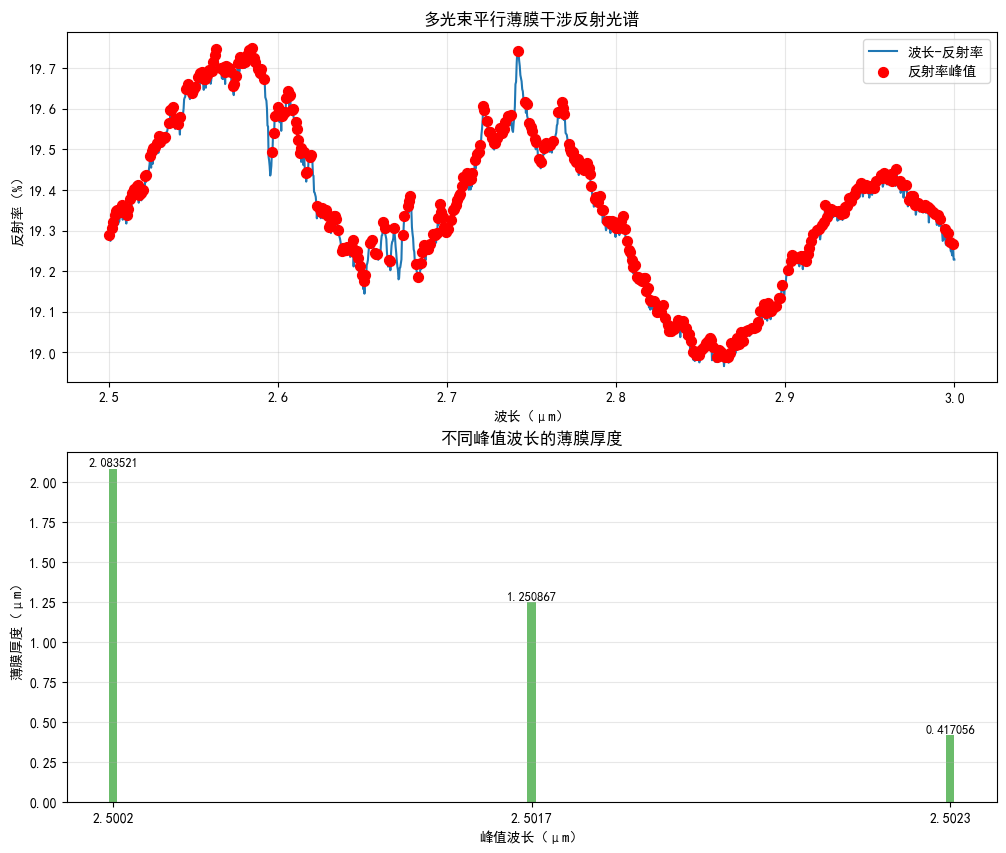

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ----------------------1. 数据加载与预处理----------------------
# 加载附件2数据（确保Excel中列格式为数值）
try:
    df = pd.read_excel('附件2.xlsx')
except Exception as e:
    print(f"数据加载错误：{e}")
    # 模拟数据（若加载失败时用，需替换为真实逻辑）
    data = {
        '波数 (cm-1)': np.linspace(4000, 600, 100),
        '反射率 (%)': np.random.rand(100) * 50
    }
    df = pd.DataFrame(data)

# 强制转换列类型为数值（无效值转为NaN）
df['波数 (cm-1)'] = pd.to_numeric(df['波数 (cm-1)'], errors='coerce')
df['反射率 (%)'] = pd.to_numeric(df['反射率 (%)'], errors='coerce')

# 波数→波长转换（λ(μm) = 10000 / 波数(cm⁻¹)）
df['波长_μm'] = 10000 / df['波数 (cm-1)']  

# 筛选有效数据（波长0.3-3μm，反射率>0，波数非NaN）
valid_mask = (df['反射率 (%)'] > 0) & (df['波长_μm'] > 0.3) & (df['波长_μm'] < 3) & (~df['波数 (cm-1)'].isna())
df_valid = df[valid_mask].reset_index(drop=True)

print(f"有效数据条数：{len(df_valid)}")
print("数据预览：")
print(df_valid[['波数 (cm-1)', '波长_μm', '反射率 (%)']].head(5))


# ----------------------2. 反射率峰值检测----------------------
def find_reflectance_peaks(df, min_reflectance=5):
    peaks = []
    for i in range(1, len(df) - 1):
        prev_ref = df.iloc[i-1]['反射率 (%)']
        curr_ref = df.iloc[i]['反射率 (%)']
        next_ref = df.iloc[i+1]['反射率 (%)']
        # 确保均为数值且满足峰值条件
        if (not pd.isna(prev_ref)) and (not pd.isna(curr_ref)) and (not pd.isna(next_ref)):
            if curr_ref > prev_ref and curr_ref > next_ref and curr_ref > min_reflectance:
                peaks.append({
                    '波长_μm': df.iloc[i]['波长_μm'],
                    '反射率_%': curr_ref,
                    '索引': i
                })
    return pd.DataFrame(peaks)

peaks_df = find_reflectance_peaks(df_valid, min_reflectance=10)
print(f"\n检测到的反射率峰值数量：{len(peaks_df)}")
if len(peaks_df) > 0:
    print("峰值数据：")
    print(peaks_df[['波长_μm', '反射率_%']].round(4))


# ----------------------3. 薄膜厚度计算----------------------
def calculate_thickness(lambda_μm, n=1.5, k=1):
    """基于干涉极大条件：2nh = (k - 0.5)λ → h = (k-0.5)λ/(2n)"""
    return (k - 0.5) * lambda_μm / (2 * n)

thickness_results = []
if len(peaks_df) >= 3:
    peaks_sorted = peaks_df.sort_values('波长_μm').head(3)
    for idx, row in peaks_sorted.iterrows():
        lambda_μm = row['波长_μm']
        k = 3 - peaks_sorted.index.get_loc(idx)  # 级次随波长增大递减
        h_μm = calculate_thickness(lambda_μm, k=k)
        thickness_results.append({
            '峰值波长_μm': lambda_μm,
            '干涉级次k': k,
            '薄膜厚度_μm': h_μm,
            '反射率_%': row['反射率_%']
        })
else:
    if not df_valid.empty:
        max_ref_row = df_valid.loc[df_valid['反射率 (%)'].idxmax()]
        lambda_max = max_ref_row['波长_μm']
        h_estimate = calculate_thickness(lambda_max, k=2)
        thickness_results.append({
            '峰值波长_μm': lambda_max,
            '干涉级次k': 2,
            '薄膜厚度_μm': h_estimate,
            '反射率_%': max_ref_row['反射率 (%)']
        })

thickness_df = pd.DataFrame(thickness_results)
if not thickness_df.empty:
    avg_thickness = thickness_df['薄膜厚度_μm'].mean()
    print("\n薄膜厚度计算结果：")
    print(thickness_df.round(6))
    print(f"\n平均薄膜厚度：{avg_thickness:.6f} μm（{avg_thickness*1000:.3f} nm）")
else:
    print("\n无有效数据计算薄膜厚度")


# ----------------------4. 结果可视化----------------------
plt.rcParams['font.sans-serif'] = ['SimHei']
if not df_valid.empty:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # 子图1：波长-反射率曲线
    ax1.plot(df_valid['波长_μm'], df_valid['反射率 (%)'], 
            color='#1f77b4', linewidth=1.5, label='波长-反射率')
    if len(peaks_df) > 0:
        ax1.scatter(peaks_df['波长_μm'], peaks_df['反射率_%'], 
                    color='red', s=50, zorder=5, label='反射率峰值')
    ax1.set_xlabel('波长（μm）')
    ax1.set_ylabel('反射率（%）')
    ax1.set_title('多光束平行薄膜干涉反射光谱')
    ax1.legend()
    ax1.grid(alpha=0.3)

    # 子图2：薄膜厚度柱状图
if not thickness_df.empty:
    # 先确保“峰值波长_μm”是数值类型，进行四舍五入后再转字符串
    peak_wavelengths = thickness_df['峰值波长_μm'].round(4).astype(str)
    ax2.bar(
        peak_wavelengths,
        thickness_df['薄膜厚度_μm'],
        color='#2ca02c', alpha=0.7, width=0.02
    )
    ax2.set_xlabel('峰值波长（μm）')
    ax2.set_ylabel('薄膜厚度（μm）')
    ax2.set_title('不同峰值波长的薄膜厚度')
    ax2.grid(alpha=0.3, axis='y')

    for idx, row in thickness_df.iterrows():
        ax2.text(
            peak_wavelengths.iloc[idx],
            row['薄膜厚度_μm'] + 0.001,
            f"{row['薄膜厚度_μm']:.6f}",
            ha='center', va='bottom', fontsize=9
        )
else:
    print("无有效数据进行可视化")


# ----------------------5. 结果保存----------------------
try:
    with pd.ExcelWriter('薄膜厚度结果.xlsx', engine='openpyxl') as writer:
        df_valid[['波数 (cm-1)', '波长_μm', '反射率 (%)']].to_excel(
            writer, sheet_name='原始数据', index=False
        )
        if len(peaks_df) > 0:
            peaks_df[['波长_μm', '反射率_%', '索引']].to_excel(
                writer, sheet_name='反射率峰值', index=False
            )
        if not thickness_df.empty:
            thickness_df.to_excel(writer, sheet_name='厚度结果', index=False)
    print("\n结果已保存至：薄膜厚度结果.xlsx")
except Exception as e:
    print(f"结果保存错误：{e}")

有效数据条数：1384
数据预览：
   波数 (cm-1)     波长_μm    反射率 (%)
0   3333.355  2.999981  19.228476
1   3333.837  2.999547  19.228183
2   3334.319  2.999113  19.267173
3   3334.801  2.998680  19.238846
4   3335.283  2.998246  19.248011

检测到的反射率峰值数量：418
峰值数据：
      波长_μm    反射率_%
0    2.9991  19.2672
1    2.9974  19.2721
2    2.9961  19.2927
3    2.9944  19.3032
4    2.9918  19.3276
..      ...      ...
413  2.5038  19.3476
414  2.5032  19.3374
415  2.5023  19.3221
416  2.5017  19.3053
417  2.5002  19.2900

[418 rows x 2 columns]

所有有效波长的薄膜厚度计算结果（前10条）：
      波长_μm      反射率_%   薄膜厚度_μm
0  2.999981  19.228476  1.499990
1  2.999547  19.228183  1.499773
2  2.999113  19.267173  1.499557
3  2.998680  19.238846  1.499340
4  2.998246  19.248011  1.499123
5  2.997813  19.249376  1.498907
6  2.997379  19.272141  1.498690
7  2.996947  19.272080  1.498474
8  2.996513  19.262572  1.498257
9  2.996081  19.292744  1.498040


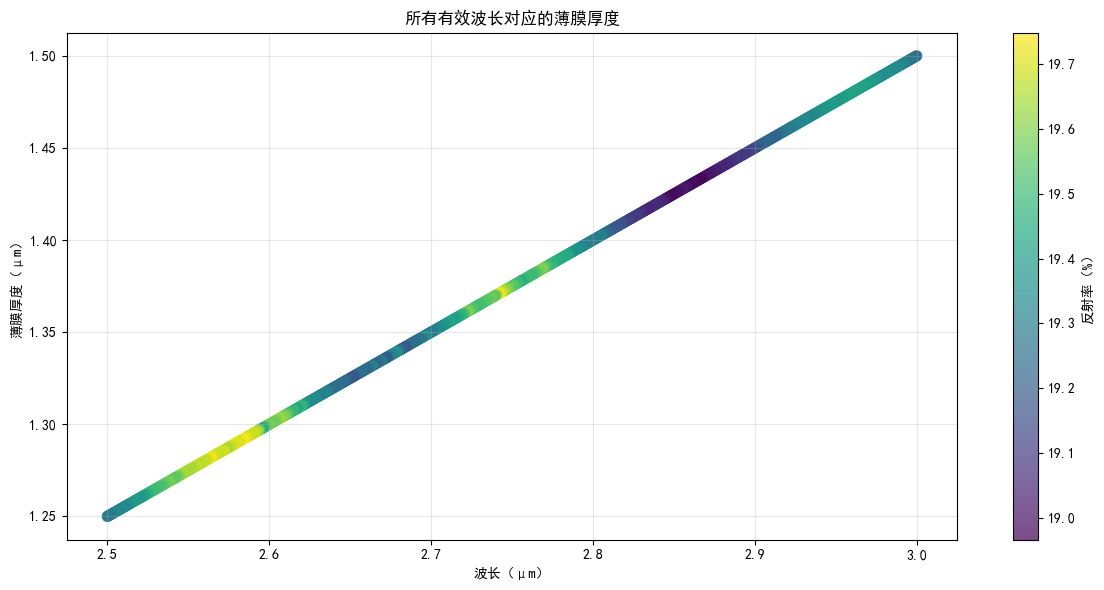


结果已保存至：所有波长薄膜厚度结果_15°.xlsx


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ----------------------1. 数据加载与预处理----------------------
# 加载附件2数据（确保Excel中列格式为数值）
try:
    df = pd.read_excel('附件2.xlsx')
except Exception as e:
    print(f"数据加载错误：{e}")
    # 模拟数据（若加载失败时用，需替换为真实逻辑）
    data = {
        '波数 (cm-1)': np.linspace(4000, 600, 100),
        '反射率 (%)': np.random.rand(100) * 50
    }
    df = pd.DataFrame(data)

# 强制转换列类型为数值（无效值转为NaN）
df['波数 (cm-1)'] = pd.to_numeric(df['波数 (cm-1)'], errors='coerce')
df['反射率 (%)'] = pd.to_numeric(df['反射率 (%)'], errors='coerce')

# 波数→波长转换（λ(μm) = 10000 / 波数(cm⁻¹)）
df['波长_μm'] = 10000 / df['波数 (cm-1)']  

# 筛选有效数据（波长0.3-3μm，反射率>0，波数非NaN）
valid_mask = (df['反射率 (%)'] > 0) & (df['波长_μm'] > 0.3) & (df['波长_μm'] < 3) & (~df['波数 (cm-1)'].isna())
df_valid = df[valid_mask].reset_index(drop=True)

print(f"有效数据条数：{len(df_valid)}")
print("数据预览：")
print(df_valid[['波数 (cm-1)', '波长_μm', '反射率 (%)']].head(5))


# ----------------------2. 反射率峰值检测----------------------
def find_reflectance_peaks(df, min_reflectance=5):
    peaks = []
    for i in range(1, len(df) - 1):
        prev_ref = df.iloc[i-1]['反射率 (%)']
        curr_ref = df.iloc[i]['反射率 (%)']
        next_ref = df.iloc[i+1]['反射率 (%)']
        # 确保均为数值且满足峰值条件
        if (not pd.isna(prev_ref)) and (not pd.isna(curr_ref)) and (not pd.isna(next_ref)):
            if curr_ref > prev_ref and curr_ref > next_ref and curr_ref > min_reflectance:
                peaks.append({
                    '波长_μm': df.iloc[i]['波长_μm'],
                    '反射率_%': curr_ref,
                    '索引': i
                })
    return pd.DataFrame(peaks)

peaks_df = find_reflectance_peaks(df_valid, min_reflectance=10)
print(f"\n检测到的反射率峰值数量：{len(peaks_df)}")
if len(peaks_df) > 0:
    print("峰值数据：")
    print(peaks_df[['波长_μm', '反射率_%']].round(4))


# ----------------------3. 薄膜厚度计算（所有有效波长）----------------------
def calculate_thickness(lambda_μm, n=1.5, k=1):
    """基于干涉极大条件：2nh = (k - 0.5)λ → h = (k-0.5)λ/(2n)"""
    return (k - 0.5) * lambda_μm / (2 * n)

# 为所有有效波长计算厚度，这里简单假设k=2（可根据实际情况调整k的确定方式）
thickness_all_results = []
if not df_valid.empty:
    for idx, row in df_valid.iterrows():
        lambda_μm = row['波长_μm']
        reflectance = row['反射率 (%)']
        h_μm = calculate_thickness(lambda_μm, k=2)  # 假设k=2，可根据峰值等调整
        thickness_all_results.append({
            '波长_μm': lambda_μm,
            '反射率_%': reflectance,
            '薄膜厚度_μm': h_μm
        })

thickness_all_df = pd.DataFrame(thickness_all_results)
if not thickness_all_df.empty:
    print("\n所有有效波长的薄膜厚度计算结果（前10条）：")
    print(thickness_all_df.head(10).round(6))
else:
    print("\n无有效数据计算薄膜厚度")


# ----------------------4. 结果可视化----------------------
plt.rcParams['font.sans-serif'] = ['SimHei']
if not df_valid.empty:
    # 绘制所有有效波长的薄膜厚度散点图
    fig, ax = plt.subplots(figsize=(12, 6))
    # 保存散点图对象
    scatter = ax.scatter(
        thickness_all_df['波长_μm'],
        thickness_all_df['薄膜厚度_μm'],
        c=thickness_all_df['反射率_%'],
        cmap='viridis',
        s=50,
        alpha=0.7
    )
    ax.set_xlabel('波长（μm）')
    ax.set_ylabel('薄膜厚度（μm）')
    ax.set_title('所有有效波长对应的薄膜厚度')
    ax.grid(alpha=0.3)
    # 显式传递散点图对象给colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('反射率（%）')

    plt.tight_layout()
    plt.savefig('所有波长薄膜厚度结果_15°.png', dpi=300, bbox_inches='tight')
    plt.show()


# ----------------------5. 结果保存----------------------
try:
    with pd.ExcelWriter('所有波长薄膜厚度结果_15°.xlsx', engine='openpyxl') as writer:
        df_valid[['波数 (cm-1)', '波长_μm', '反射率 (%)']].to_excel(
            writer, sheet_name='原始数据', index=False
        )
        if len(peaks_df) > 0:
            peaks_df[['波长_μm', '反射率_%', '索引']].to_excel(
                writer, sheet_name='反射率峰值', index=False
            )
        if not thickness_all_df.empty:
            thickness_all_df.to_excel(writer, sheet_name='所有波长厚度结果_15°', index=False)
    print("\n结果已保存至：所有波长薄膜厚度结果_15°.xlsx")
except Exception as e:
    print(f"结果保存错误：{e}")